<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P4.1_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# P4.1: Node Classification (using Graph Neural Networks)
In this tutorial we will explore Graph Neural Networks (GNNs), and apply them to the task of classifying individual nodes in a graph. To do so, we will use PyTorch and the PyTorch Geometric library. PyTorch Geometric is an extension that implements deep learning methods based on graphs and other irregular structures, allowing us to explore such networks without having to code everything by hand (see [[1]](#pytorchgeomintro) for more information).

The main (learning) objectives of this tutorial are as follows:

*   Providing an overview of graphs/graph data and the problem of classifying nodes in a graph.
*   How to structure graph data (for PyTorch geometric specifically - although the general concept extends to arbitrary libraries/implementations).
*   Providing an overview of the general structure of GNNs, alongside a discussion of the specific GNN-variant we use, GraphSAGE[[2]](#hamilton2017).
*   How to build a GNN, and showing what the advantage is of incorporating the graph structure into the model.
*   How to train a GNN with the goal of classifying nodes.











#  Preparation
To start, we install the necessary packages (that are not pre-installed on the Google Colab environment), set up the formatting of cells in the notebook, and download the (meta)data we consider in this tutorial.

In [1]:
# PyTorch Geometric is not part of the standard Colab packages, we must install it ourselves
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [2]:
# We want to wrap words in output cells, and limit the height of the output cells.
from IPython.display import HTML, display, Javascript
def modify_cell():
  display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 450})'))

get_ipython().events.register('pre_run_cell', modify_cell)

In [3]:
# We download the data we use (nodes and edges), alongside some metadata.
# It's stored as a .zip, so we download this zip and unzip / load the data into memory as desired.

from zipfile import ZipFile
import requests
import io
import pickle
import pandas as pd

def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/RpRon4oDfDSiGeH/download')

# load dataframe with node information
feature_names = ['w_{}'.format(ii) for ii in range(1433)]  # we have 1433 words
column_names =  feature_names + ['subject']
node_data = pd.read_csv(io.BytesIO(data['cora_paper.tsv']), sep='\t', header=None, names=column_names)
# make sure it is sorted on index
node_data.sort_index(inplace=True)

# load dataframe with edge information
edge_data = pd.read_csv(io.BytesIO(data['cora_cite.tsv']), sep='\t', header=None, names=['target', 'source'])
# make sure it is sorted on index
edge_data.sort_index(inplace=True)

# load dictionary with additional paper metadata
paper_information = pickle.load(io.BytesIO(data['paper_information.pkl']))

<IPython.core.display.Javascript object>

# Problem formulation
The type of data we focus on is graph data, i.e., some graph $\mathcal{G} = (\mathcal{V},\mathcal{E})$. The specific problem we tackle is that of node classification: For each node $\mathcal{v} \in \mathcal{V}$, we seek to assign a specific class $\mathcal{c} \in \mathcal{C}$ to the node, where $\mathcal{C}$ is a predefined set of classes.

We can define our data $X$ as the graph $\mathcal{G} = (\mathcal{V},\mathcal{E})$, whereas labels $Y$ can defined by as a map for each node to a class, i.e., $Y = f: \mathcal{V} \rightarrow C$

## Dataset: Citation graph of (computer science) papers
In this tutorial, we consider the Cora dataset[[3]](#cora). This dataset is a graph, where each node $\mathcal{v} \in \mathcal{V}$ indicates a scientific publication, and each (directed) edge $(i, j) \in \mathcal{E}$ indicates one paper citing another (note that $i, j \in \mathcal{V}$). The classes consist of the category of the paper. Each paper is assigned to one of seven categories $c \in \mathcal{C}$, which are 

```
['Theory', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Case_Based', 'Rule_Learning']
```

Next, we consider the properties associated with each node. Each paper is associated with a vector of binary values that indicate word occurence. This vector considers 1433 unique words (the same words for each node), and for each such word, marks whether it occurs in a given paper (1) or not (0). As such, the node properties of the entire dataset can be denoted as matrix $\mathbb{Z}^{|\mathcal{V}| \times D}$, where $|\mathcal{V}|$ denotes the number of nodes and $D$ denotes the size of the word dictionary, 1433.

The data we use is described and previewed in the following cells.


In [4]:
'''
The node data: For each node, we have a vector of size 1433 indicating whether a word occurs or not
Additionally, we have a class label for each node (the rightmost column). Note that we split this off from
the remaining features (i.e., this is not a node property we feed to the model), as it would make
the classification task trivial.

We have 2708 rows in total: 2708 papers. Note that this dataset is a subgraph of a larger graph of
paper citations: The indices at the start correspond to the index in the 'true' graph. We will convert
these later such that the index corresponds to the (to be created) row-index in the node-matrix.

(Note: We could extent this problem/model by adding a word-embedding to the model 
[or using pretrained word embeddings], rather than only considering the word occurence!)
'''
node_data

<IPython.core.display.Javascript object>

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_1394,w_1395,w_1396,w_1397,w_1398,w_1399,w_1400,w_1401,w_1402,w_1403,w_1404,w_1405,w_1406,w_1407,w_1408,w_1409,w_1410,w_1411,w_1412,w_1413,w_1414,w_1415,w_1416,w_1417,w_1418,w_1419,w_1420,w_1421,w_1422,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
114,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
128,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Case_Based
1154520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neural_Networks
1154524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rule_Learning
1154525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rule_Learning


In [5]:
'''
The edge data: Each edge consists of a source and target node, where the source (i)
is the paper that cites the target (j). Again, these indices correspond to the 
indices in the 'full' graph: We will convert these such that they correspond with
the indices of the nodes we consider.
'''
edge_data

<IPython.core.display.Javascript object>

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [6]:
'''
To convert between indices from the 'true' graph and the subgraph we consider,
we create a simple map for both directions.
'''
idx_true = node_data.index
idx_true_to_idx = {idx_true[i]: i for i in range(len(idx_true))}
idx_to_idx_true = {i: idx_true[i] for i in range(len(idx_true))}

<IPython.core.display.Javascript object>

In [7]:
'''
Finally, we make a simple function to print some paper metadata corresponding to the
original dataset (stored using a pre-processed dictionary). This data is not actually 
used in the model, rather, we can use it to get an idea of the 'raw' data we are 
modeling / classifying.
'''
def print_paper(e_idx):
    true_idx = idx_to_idx_true[e_idx]
    paper_info = paper_information[true_idx]
    print(paper_info['title'])
    print()
    print(paper_info['author'])
    print(paper_info['date'])
    print()
    print('Abstract:', paper_info['abstract'])

<IPython.core.display.Javascript object>

In [8]:
print_paper(3)

<IPython.core.display.Javascript object>

Generalized Markov Decision Processes: Dynamic-programming and Reinforcement-learning Algorithms

Csaba Szepesvari Michael L. Littman
November 25, 1997

Abstract: The problem of maximizing the expected total discounted reward in a completely observable Markovian environment, i.e., a Markov decision process (mdp), models a particular class of sequential decision problems. Algorithms have been developed for making optimal decisions in mdps given either an mdp specification or the opportunity to interact with the mdp over time. Recently, other sequential decision-making problems have been studied prompting the development of new algorithms and analyses. We describe a new generalized model that subsumes mdps as well as many of the recent variations. We prove some basic results concerning this model and develop generalizations of value iteration, policy iteration, model-based reinforcement-learning, and Q-learning that can be used to make optimal decisions in the generalized model under var

## Creating the model input
We must make slight adaptations to use the dataset in a (PyTorch [Geometric]) model. The three tensors we must create are the node data ($x$), the node labels ($y$) and the edge data ($edge\_index$). 

This notation might seem familiar: We could consider the problem of classifying nodes in a graph as a special case of classifying items in a dataset, where the items are nodes and the graph is the dataset. The difference lies in the additional structure a graph provides: Nodes are very much related to eachother (and this relation provides us with additional information), whereas datapoints in an arbitrary classification-problem can often be considered individually.

In the following cells, we will reformat the $node\_data$ and $edge\_data$ dataframes we have described before, in order to be fit for usage in PyTorch Geometric.

In [9]:
# Import the relevant libraries
import torch
from torch_geometric import utils
from torch_geometric.data import Data

<IPython.core.display.Javascript object>

In [10]:
'''
As indicated before, the node_data object also contains the subject label of each node.
Since we do not want the node features to include this, we remove it from the dataframe.
'''
node_data_no_class = node_data.drop('subject', axis=1)
node_data_no_class

<IPython.core.display.Javascript object>

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_1393,w_1394,w_1395,w_1396,w_1397,w_1398,w_1399,w_1400,w_1401,w_1402,w_1403,w_1404,w_1405,w_1406,w_1407,w_1408,w_1409,w_1410,w_1411,w_1412,w_1413,w_1414,w_1415,w_1416,w_1417,w_1418,w_1419,w_1420,w_1421,w_1422,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432
35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1154520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1154524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1154525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
'''
This gives us the matrix corresponding to the nodes and their properties. To use it
in a model, we simply convert the dataframe to a tensor, giving us tensor x.
'''
x = torch.tensor(node_data_no_class.values, dtype=torch.float)
x, x.shape

<IPython.core.display.Javascript object>

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), torch.Size([2708, 1433]))

In [12]:
'''
Next, we consider the label column, 'subject'. We split this from the main dataframe first.
'''
node_data_class = node_data['subject']
node_data_class

<IPython.core.display.Javascript object>

35             Genetic_Algorithms
40             Genetic_Algorithms
114        Reinforcement_Learning
117        Reinforcement_Learning
128        Reinforcement_Learning
                    ...          
1154500                Case_Based
1154520           Neural_Networks
1154524             Rule_Learning
1154525             Rule_Learning
1155073             Rule_Learning
Name: subject, Length: 2708, dtype: object

In [13]:
'''
We convert the name-based labels to integers. To do so, we create a mapping of all labels
to their respective integer class, and map the values using this mapping.
'''
labels = list(set(node_data_class))  # create list of unique elements in subject -> the labels
label_to_idx = {labels[i]: i for i in range(len(labels))}
idx_to_label = {i: labels[i] for i in range(len(labels))}
print('Classes:', idx_to_label, '\n')

node_data_class_val = node_data_class.map(label_to_idx) # map the name-based labels to integers
node_data_class_val

<IPython.core.display.Javascript object>

Classes: {0: 'Theory', 1: 'Reinforcement_Learning', 2: 'Probabilistic_Methods', 3: 'Neural_Networks', 4: 'Genetic_Algorithms', 5: 'Rule_Learning', 6: 'Case_Based'} 



35         4
40         4
114        1
117        1
128        1
          ..
1154500    6
1154520    3
1154524    5
1154525    5
1155073    5
Name: subject, Length: 2708, dtype: int64

In [14]:
'''
Next, we convert this list to a tensor, containing a class-label for each node: y.

Note that we do not need to convert labels to a one-hot (probability distribution) format,
the PyTorch categorical crossentropy loss takes care of matching the integer labels to the 
outputted probability distributions. 
'''
y = torch.tensor(node_data_class_val.values, dtype=torch.long)
y, y.shape

<IPython.core.display.Javascript object>

(tensor([4, 4, 1,  ..., 5, 5, 5]), torch.Size([2708]))

In [15]:
'''
To create the edge_index tensor, we must convert the edge_data dataframe.
'''
edge_data

<IPython.core.display.Javascript object>

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [16]:
'''
The format of the edge_index is (2, |E|), where |E| is the number of edges. The two
rows in this matrix indicate the start and end vertex of an edge, respectively.
(e.g.,  [[0, 2, 3]
         [1, 3, 2]] = edges {(0, 1), (2, 3), (3, 2)})

We want to treat our graph as an undirected graph, as we assume that both 'a cites b'
and 'a is cited by b' should let information 'flow' from one node (paper) to the other.

Furthermore, the current edge_data has indices corresponding to the graph containing
many more papers (e.g., the first index is 35, not 0). Our edge_index must contain indices 
corresponding to rows in our x and y, the subgraph considered. As such, we must do 2 things:
    1. For each edge, map the indices from edge_data to the indices corresponding to the correct rows
    2. Insert each edge in both directions, as we treat it as an undirected graph.
'''

# we create a set of all edges
# we use a set to make sure that we don't add the same edge twice. This shouldn't
# be the case anyway, it is more of a precaution in case the data is noisy.
all_edge = set()  
for t, s in edge_data.itertuples(index=False):
    # for each target and source in edge_data, map the idx to those corresponding
    # to the rows of x and y, using the maps we created before
    t = idx_true_to_idx[t]
    s = idx_true_to_idx[s]
    all_edge.add((s, t))
    all_edge.add((t, s))  # and add them in both directions!

# we have a set containing all edges, in both directions
# we create a source and target list, as this is the format of edge_index
source_edges = []
target_edges = []
for s, t in all_edge:
    source_edges.append(s)
    target_edges.append(t)
# finally, we convert our edge data to a tensor
edge_index = torch.tensor([source_edges, target_edges], dtype=torch.long)
edge_index, _ = utils.sort_edge_index(edge_index)  # and sort them
edge_index, edge_index.shape

<IPython.core.display.Javascript object>

(tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [  13,   21,   31,  ...,  152,  345, 1897]]), torch.Size([2, 10556]))

In [17]:
'''
x, y and edge_index together are the dataset: Convert it to a pytorch_geometric dataset object.
'''
data = Data(x=x, edge_index=edge_index, y=y)
data

<IPython.core.display.Javascript object>

Data(edge_index=[2, 10556], x=[2708, 1433], y=[2708])

The data object contains the entire dataset. For training, we want to consider the situation where only a limited number of labels are available, also known as *semi-supervised learning*. The network is allowed to see the entire graph, however, only a small set of nodes will have labels. Consequently, only these nodes can be used to calculate the loss.

To accomplish this we will create masks for the nodes, where a mask is an array of booleans (of the same length as x/y) with 'TRUE' indicating that a node can be used and 'FALSE' indicating that it cannot. By using this mask while training we can use only a subset of nodes for the loss calculation, even when we show the network all nodes during the forward pass (in order to create node embeddings). Additionally, we use this technique to select a subset of nodes to use for calculating the test accuracy.

In [18]:
def add_mask(data, num_train_per_class=20, num_val=500, num_test=1000):
    # get dimensions of dataset
    num_data = int(data.x.shape[0])
    num_features = int(data.x.shape[1])
    num_classes = int(max(data.y)+1)
    
    # handle train mask
    data.train_mask = torch.zeros(num_data, dtype=torch.bool)
    data.train_mask.fill_(False) # initially, fill the entire mask with False
    for c in range(num_classes): # for each class
        idx = (data.y == c).nonzero(as_tuple=False).view(-1) # find the indices
        idx = idx[torch.randperm(idx.size(0))[:num_train_per_class]] # pick a random permutation of them, up to num_train_per_class elements
        data.train_mask[idx] = True # set these indices to True

    remaining = (~data.train_mask).nonzero(as_tuple=False).view(-1) # get the 'False' nodes
    remaining = remaining[torch.randperm(remaining.size(0))] # and take a random permutation

    # handle validation mask
    if num_val > 0:
        data.val_mask = torch.zeros(num_data, dtype=torch.bool)
        data.val_mask.fill_(False) # initialize the validation mask
        data.val_mask[remaining[:num_val]] = True # and set num_val to True, using the remaining permutation

    # handle test mask
    if num_test > 0:
        data.test_mask = torch.zeros(num_data, dtype=torch.bool)
        data.test_mask.fill_(False) # initialize the test mask
        data.test_mask[remaining[num_val:num_val + num_test]] = True # and set num_test to true, using the remaining permutation

<IPython.core.display.Javascript object>

In [19]:
'''
To finalize, we add a training and test mask: We only show 20 labels for each class
while training, and create a test set with 1000 labels (none of which are used during training)
'''
add_mask(data, num_train_per_class=20, num_val=0, num_test=1000)
data

<IPython.core.display.Javascript object>

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], x=[2708, 1433], y=[2708])

# Node Classification
The purpose of this tutorial is to build a model that can classify the papers into one of seven categories, using GNNs. We will demonstrate this using both the GNN-based approach and a naïve approach, which simply takes nodes as datapoints and sets it up as a traditional classification task. The latter serves as a confirmation that we are not throwing more complexity at the task than necessary.

In [20]:
'''
The dataset-specific variables the models will use
'''
num_features = int(data.x.shape[1])
num_classes = int(max(data.y)+1)

<IPython.core.display.Javascript object>

## Naïve approach
For the first approach, we aim to train a classifier that predicts the category directly from the paper's attributes, the associated word vector. As such, we only use **data.x** and **data.y**, **data.edge_index** is not used. A simple overview of this data is given in Figure 1 below.

<div>
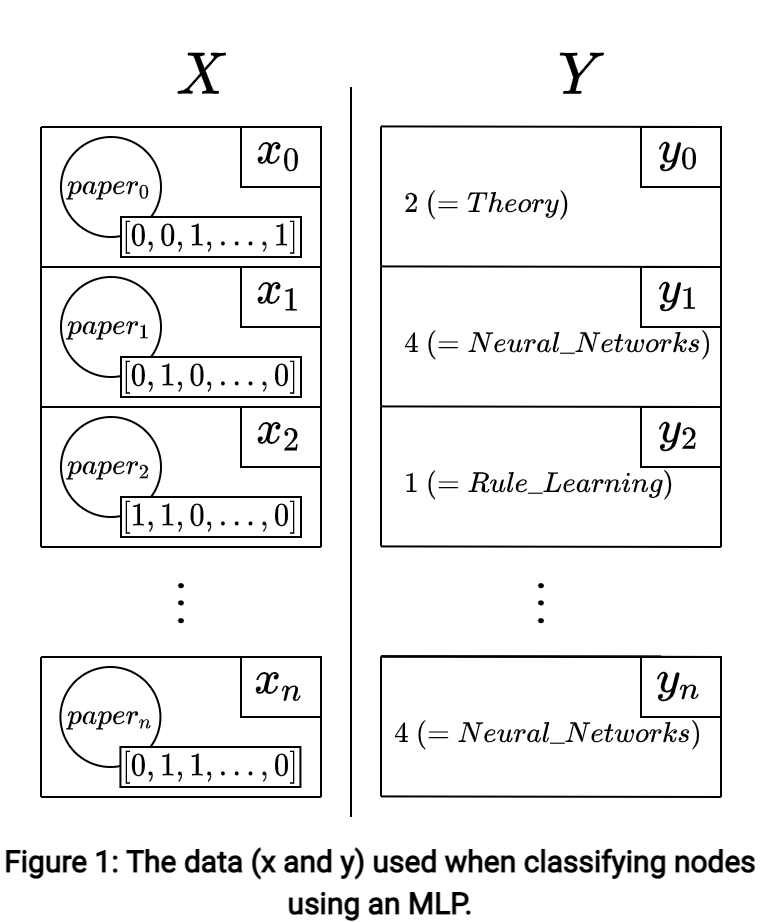
</div>

Creating this classifier is straightforward: We define a torch.nn.Module consisting of a few dense layers. In the forward pass, we simply propagate x (our nodes / word-occurence vectors) through these layers to predict the category.

In [21]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)  # dense layer outputting (x_size, hidden_channels)
        x = x.relu()  # apply an activation function
        x = F.dropout(x, p=0.7, training=self.training)  # apply (a high) dropout, as we will train on few datapoints
        x = self.lin2(x)  # dense layer outputting (x_size, num_classes): the (one-hot) prediction
        return x

<IPython.core.display.Javascript object>

In [22]:
'''
Training the MLP
'''
model_mlp = MLP(hidden_channels=16)  # initialize our MLP with a hidden size of 16
print(model_mlp)
loss_func = torch.nn.CrossEntropyLoss()  # as this is a classification task, we use CCE
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.01, weight_decay=5e-4)  # Adam usually works well

def train_mlp():
    model_mlp.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_mlp(data.x)  # propagate the data through the model
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_mlp(mask):
    model_mlp.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_mlp(data.x)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc

train_accs = []
test_accs = []
epochs = 50
for epoch in range(1, epochs+1):  # we train for 50 epochs
    loss = train_mlp()  # do one training step over the entire dataset
    train_acc = test_mlp(data.train_mask)  # compute the training accuracy
    test_acc = test_mlp(data.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

<IPython.core.display.Javascript object>

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch: 001, Loss: 1.9615, Train Acc: 0.2500, Test Acc: 0.1130
Epoch: 002, Loss: 1.9239, Train Acc: 0.3500, Test Acc: 0.1750
Epoch: 003, Loss: 1.8903, Train Acc: 0.4286, Test Acc: 0.1990
Epoch: 004, Loss: 1.8326, Train Acc: 0.4786, Test Acc: 0.2230
Epoch: 005, Loss: 1.7843, Train Acc: 0.6000, Test Acc: 0.2490
Epoch: 006, Loss: 1.7177, Train Acc: 0.6643, Test Acc: 0.2720
Epoch: 007, Loss: 1.6856, Train Acc: 0.7429, Test Acc: 0.2990
Epoch: 008, Loss: 1.5957, Train Acc: 0.8429, Test Acc: 0.3260
Epoch: 009, Loss: 1.5181, Train Acc: 0.8786, Test Acc: 0.3480
Epoch: 010, Loss: 1.4555, Train Acc: 0.9357, Test Acc: 0.3880
Epoch: 011, Loss: 1.4400, Train Acc: 0.9429, Test Acc: 0.4050
Epoch: 012, Loss: 1.3757, Train Acc: 0.9643, Test Acc: 0.4270
Epoch: 013, Loss: 1.3022, Train Acc: 0.9643, Test Acc: 0.4530
Epoch: 014, Loss: 1.2770, Train Acc: 0.9643, Test Acc: 0.4740
Ep

In [23]:
'''
To get an overview of the accuracy over the training period, we define a simple function
to plot the saved accuracies.
'''
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

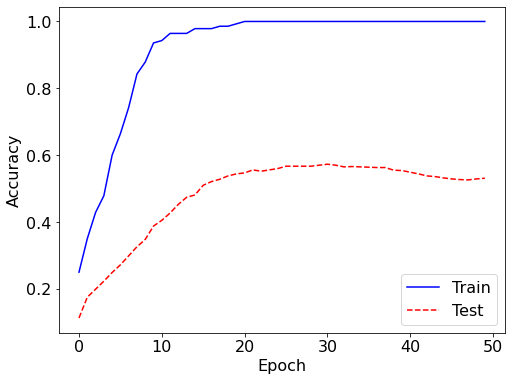

In [24]:
'''
As is visible, the model massively overfits on the small number of training datapoints
it was shown. The testing accuracy remains stuck at just above 50%.
'''
plot_train(train_accs, test_accs)

##  Graph Neural Networks
For the GNN, rather than treating the nodes as individual datapoints, we process them together as a graph. To do so, we will also incorporate the edge data ($edge\_index$) into the model. A simple overview of the data we will use is provided in Figure 2 below.

<div>
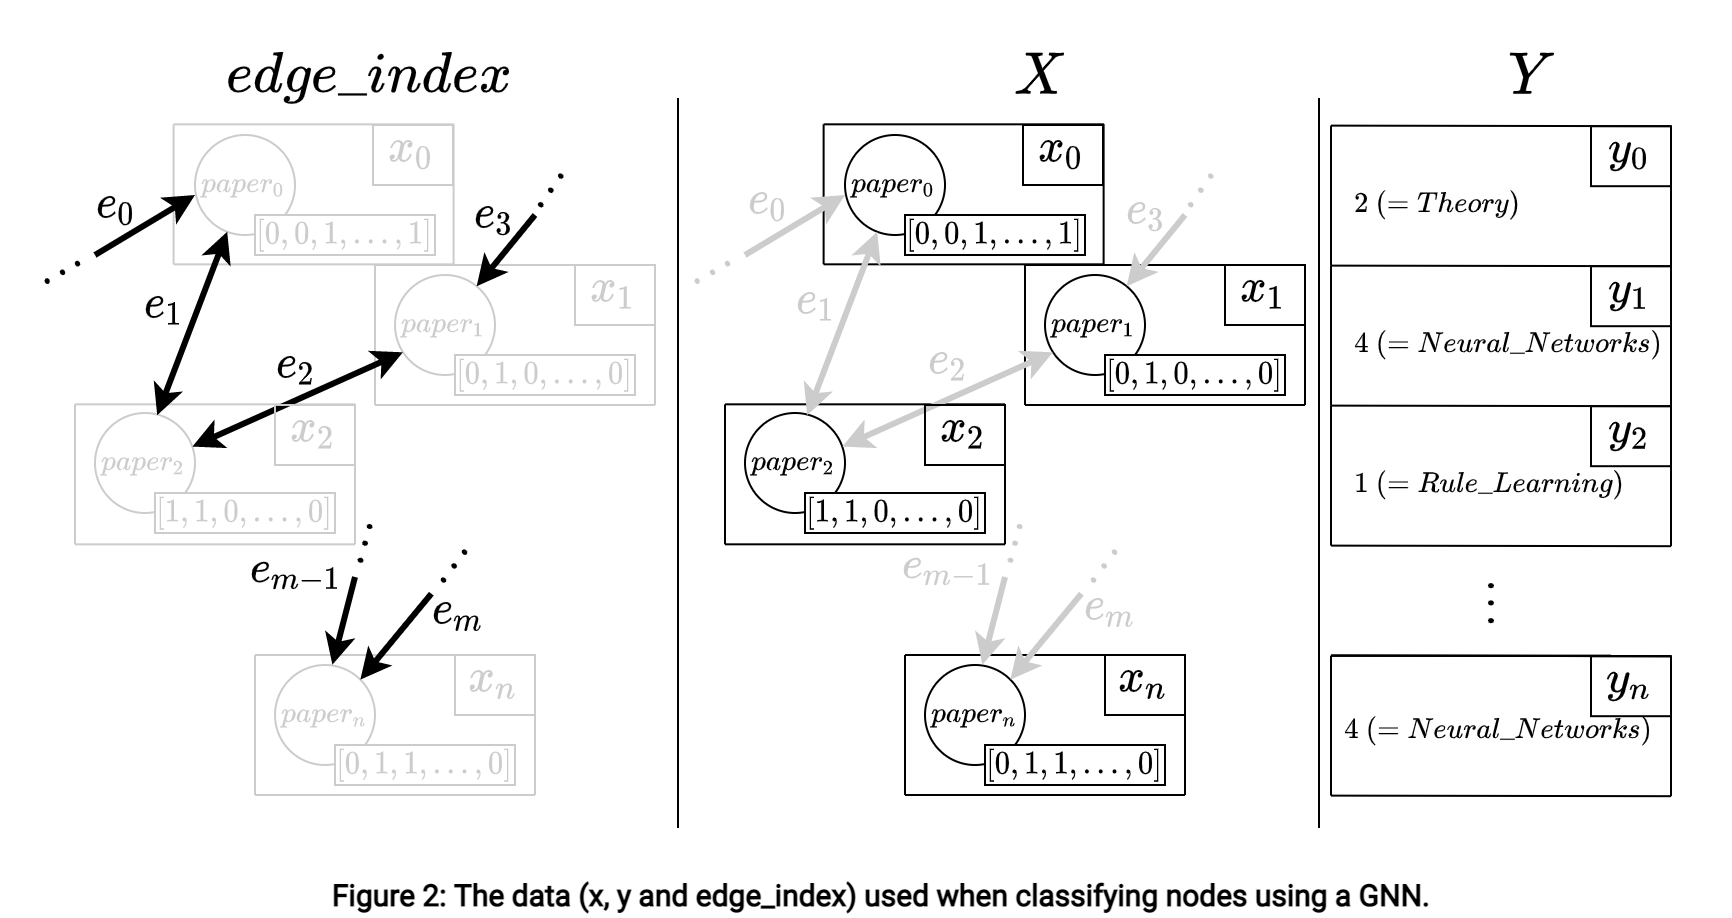
</div>

To treat this dataset as a graph with nodes being defined by **data.x** ($\mathcal{V}$), edges by **data.edge_index** ($\mathcal{E}$) and node-labels in **data.y** ($f: \mathcal{V} \rightarrow C$), we will use a Graph Neural Network. The GNNs we consider work according to the neural message passing framework, an algorithm that describes how node representations can be developed by propagating node information through the graph.

### Neural Message Passing

Neural Message Passing works by propagating nodes' information to their neighbors in an iterative manner: For each step, a node's internal state is updated according to some combination of its own internal state, alongside the state of its incoming neighbors. As time goes on (more steps are done), the nodes will be able to 'access' information from nodes increasingly further away in the graph, as the neighbors' values are determined by nodes increasingly further away. For a detailed description of this process, we refer to Section 6.4 in the lecture notes. A simple overview of this idea is given in Figure 3 below.

The role of the NN is to learn how to propagate messages (node information) around the graph. More formally, we can represent the update rule of the message passing algorithm from iteration $k-1$ to iteration $k$ as follows:

\begin{equation}
x_i^{(k)}=\gamma^{(k)}(x_i^{(k-1)}, \cup_{j\in \mathcal{N}(i)} \phi^{(k)}(x_i^{(k-1)}, x_j^{(k-1)}, e_{j,i}))
\end{equation}

where $\phi$ is the *edge transfer function*, $\cup$ is the *aggregation function* on the node, $\gamma$ is the *node update function* and $\mathcal{N}(i)$ is the neighborhood of node $i$. The three functions are differentiable functions, such as an MLP.

The *edge transfer function* $\phi$ takes the two nodes (from step $k-1$) corresponding to an edge ($x_i^{(k-1)}$ an $x_j^{(k-1)}$), alongside the edge information ($e_{j,i}$), and returns the message that should be propagated along this edge in step $k$.

The *aggregation function* $\cup$ takes all incoming neighbors of $x_i$, indices ${j\in \mathcal{N}(i)}$, and aggregates them according to the result of the corresponding edge transfer function for these nodes/edges, for step $k$.

The *node update function* $\gamma$ takes the current node information $x_i^{(k-1)}$, alongside the result of the aggregation function, and updates the value of node $x_i$ for step $k$.


### GraphSAGE
Many variants of GNNs exist, often conforming to this abstract update rule. The GNN-variant we consider for this tutorial is GraphSAGE[[2]](#hamilton2017). GraphSAGE's update rule, described from the ground up, is as follows:

For $\phi$: The edge transfer function is trivial. Edge information is not take into account, the node-embedding of the edge's source is propagated:
\begin{equation}
 \phi^{(k)}(x_i^{(k-1)}, x_j^{(k-1)}, e_{j,i}) = x_j^{(k-1)}
\end{equation}
For $\cup$: The aggregation function is the mean over all incoming edges, which in this case is all incoming neighbors ([[2]](#hamilton2017) also propose different aggregators - $mean$ is used in the PyTorch Geometric implementation):
\begin{equation}
\cup_{j\in \mathcal{N}(i)} = mean_{j\in \mathcal{N}(i)}(x_j^{k-1})
\end{equation}
Note that [[2]](#hamilton2017) propose not using all incoming edges, but rather sampling a number of edges from the neighborhood (at each step): their definition of $\mathcal{N}(i)$ slightly deviates from the (default) PyTorch Geometric implementation, which simply takes all neighbors. For more information on GraphSAGE's sampling procedure, we refer to Section 3.1 of the paper.

For $\gamma$: The node update function concatenates the aggregation result with the node's current state, and transforms it using a weight matrix with parameters $\theta^k$, which can be interpreted as a dense layer. After this operation, the result is put through a non-linear activation function. The resulting formula is as follows:
\begin{equation}
x_i^{(k)}=\gamma^{(k)} = \sigma\Big(W_{\theta^k}\cdot concatenate(x_i^{(k-1)}, mean_{j\in \mathcal{N}(i)}(x_j^{k-1}))\Big)
\end{equation}
Which specifies the entire update rule. Weight matrix $W_{\theta^k}$ is parametrized in the same manner as any weight in an NN is learned, and $\sigma$ is a non-linear activation, such as ReLU. Note that the PyTorch Geometric implementation of this layer does not apply an activation function, we must apply it ourselves.



The message passing algorithm and GraphSAGE are implemented by PyTorch Geometric, allowing us to easily build a GNN. We can simply create a GNN-layer (or Graph Convolution), which indicates one step in the neural message passing algorithm. Implementation-wise, it is similar to passing data $x$ through any arbitrary layer, however, we must also provide the $edge\_index$, as these two tensors are necessary to define the entire graph.

We construct our model by subclassing torch.nn.Module. We create a network with two message passing steps: We import the GraphSAGE update layer, SAGEConv, and initialize 2 such layers. The forward pass then consists of propagating $x$ and the $edge\_index$ through each graph layer, and applying any other desired activations/transformations to $x$.

The steps in the model correspond to the steps in Figure 3, to give a simple overview of the 'range' of information being spread around the graph.

In [25]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is  
                                                              # transformed to a vector of size hidden_channels

        self.conv2 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = F.dropout(x, p=0.7, training=self.training)  # attempt to combat overfitting, as we only have few labels
        x = self.conv2(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

<IPython.core.display.Javascript object>

<div>
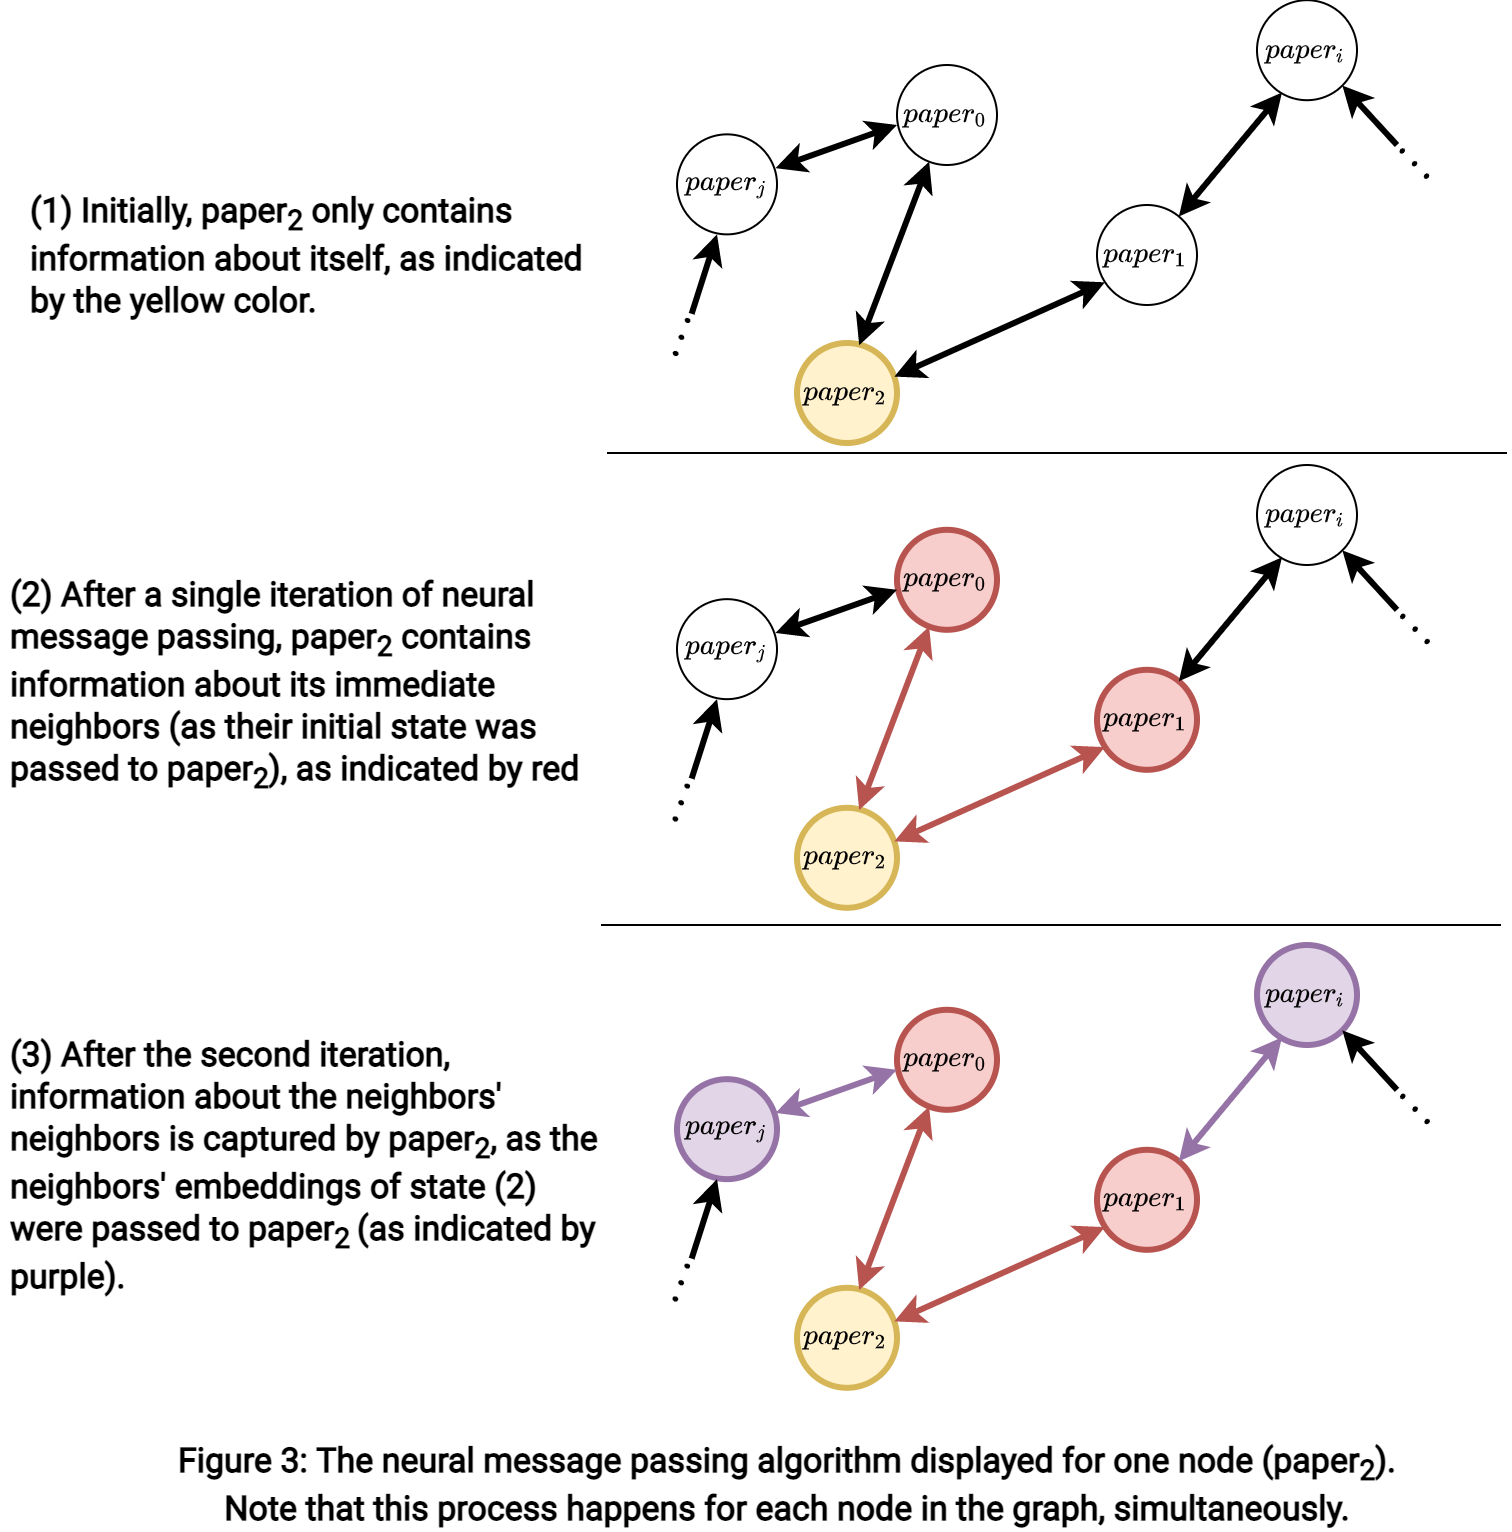
</div>

In [26]:
'''
Training the GNN
'''
model_gnn = GraphSAGE(hidden_channels=16) # initialize our GNN with a hidden size of 16
print(model_gnn)

# same loss and optimizer as before
loss_func = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.01, weight_decay=5e-4)

def train_gnn():
    model_gnn.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_gnn(data.x, data.edge_index)  # propagate the data through the model
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_gnn(mask):
    model_gnn.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_gnn(data.x, data.edge_index)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc


train_accs = []
test_accs = []
epochs = 50
for epoch in range(1, epochs+1): 
    loss = train_gnn()  # do one training step over the entire dataset
    train_acc = test_gnn(data.train_mask)  # compute the training accuracy
    test_acc = test_gnn(data.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

<IPython.core.display.Javascript object>

GraphSAGE(
  (conv1): SAGEConv(1433, 16)
  (conv2): SAGEConv(16, 7)
)
Epoch: 001, Loss: 1.9596, Train Acc: 0.3786, Test Acc: 0.3230
Epoch: 002, Loss: 1.8637, Train Acc: 0.5214, Test Acc: 0.2990
Epoch: 003, Loss: 1.7447, Train Acc: 0.6214, Test Acc: 0.3340
Epoch: 004, Loss: 1.6123, Train Acc: 0.6929, Test Acc: 0.3520
Epoch: 005, Loss: 1.4907, Train Acc: 0.7857, Test Acc: 0.3990
Epoch: 006, Loss: 1.3608, Train Acc: 0.8714, Test Acc: 0.4620
Epoch: 007, Loss: 1.2186, Train Acc: 0.9000, Test Acc: 0.5480
Epoch: 008, Loss: 1.0567, Train Acc: 0.9714, Test Acc: 0.6400
Epoch: 009, Loss: 0.9535, Train Acc: 0.9857, Test Acc: 0.7070
Epoch: 010, Loss: 0.8410, Train Acc: 0.9857, Test Acc: 0.7460
Epoch: 011, Loss: 0.7467, Train Acc: 0.9929, Test Acc: 0.7630
Epoch: 012, Loss: 0.6664, Train Acc: 0.9929, Test Acc: 0.7710
Epoch: 013, Loss: 0.6373, Train Acc: 0.9929, Test Acc: 0.7790
Epoch: 014, Loss: 0.4998, Train Acc: 0.9929, Test Acc: 0.7820
Epoch: 015, Loss: 0.4784, Train Acc: 0.9929, Test Acc: 0.7810


<IPython.core.display.Javascript object>

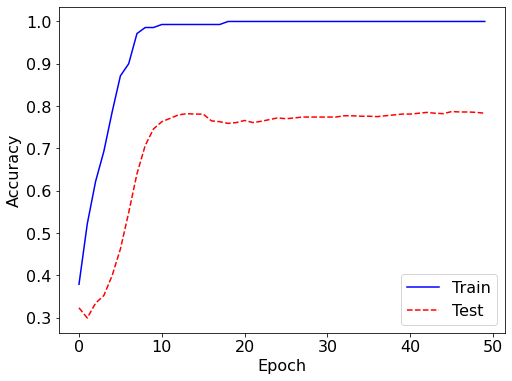

In [27]:
'''
While the model still overfits (which is difficult to avoid, given that we use
only 20 labels for each class), the test accuracy significantly increased, with
a test accuracy of just below 80%. Incorporating edge information increased the
accuracy by about 25%!
'''
plot_train(train_accs, test_accs)

# Evaluation and discussion

To finalize this tutorial, we conduct a small evaluation on what the model has learned. To get an overview of the model's final embeddings, we can plot them using TSNE[[5]](#tsne), a method for visualizing high-dimensional data in fewer (in our case 2) dimensions. The function for doing so is provided below. Additionally, we provide a function to predict individual datapoints.

In [28]:
from sklearn.manifold import TSNE
from matplotlib import cm
from matplotlib.patches import Patch

'''
A function that plots a models embeddings, and colors them either according to 
the original labels or the predicted labels. Additionally, we can highlight 
individual datapoints in this embedding.
'''
def visualize(y=None, out=None, z=None, hl=None, text_type='idx', return_z=False, color_pred=False):
    if out is None and z is None:
        print('Must supply either model or TSNE output!')
        return
    if (y is None and out is None) or (y is None and color_pred is False):
        print('Must supply either y or calculate y from out!')
        return

    if z is None: # create our embedding if it was not provided
        z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    
    if y is None and color_pred is True:
        y = out.argmax(dim=1) # if no labels are provided, take the model's output
    
    # initialize our figure / plotting related settings
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 10))
    
    ax.set_xticks([])
    ax.set_yticks([])

    colors = list(plt.cm.Paired.colors)[0:num_classes]
    labels = [idx_to_label[i] for i in range(num_classes)]
    
    c = [colors[i] for i in y]
    
    s=50
    scatter = ax.scatter(z[:, 0], z[:, 1], s=s, c=c)

    # if we provide node indices to highlight, do so
    if hl is not None:
        hl_z = z[hl]
        hl_y = y[hl]
        c = [colors[i] for i in hl_y]
        scatter_hl = ax.scatter(hl_z[:, 0], hl_z[:, 1], s=s, c=c, edgecolor='black')
        for i, h_i in enumerate(hl):  # and mark them, so we can find our nodes
            plt.arrow(hl_z[i, 0], hl_z[i, 1]-10, 0, 9, length_includes_head=True, alpha=1, head_width=2, color='black')
            if text_type == 'idx':  # either display the node's idx
                text = str(h_i)
            elif text_type == 'title':  # or the paper's title
                limit = 80
                text = paper_information[idx_to_idx_true[h_i]]['title']
                if len(text) > limit:
                    text = text[:limit-3] + '...'
            plt.text(hl_z[i, 0]-.1, hl_z[i, 1]-10.5, text, horizontalalignment='center', verticalalignment='top', fontsize=10,
                    bbox=dict(facecolor='gray', alpha=0.3, edgecolor='black', pad=1.0))
            
    # create our legend
    handles = [Patch(color=c, label=l) for c, l in zip(colors, labels)]
    ax.legend(handles=handles)
    plt.show()

    # rescale the cell this is ran on, and center-align the output
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 750})'))
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))

    if return_z:
        return z

def predict_paper(e_idx):
    prediction = int(out[e_idx].argmax())
    true = int(y[e_idx])
    prediction_class = idx_to_label[prediction]
    print('Predicted:', idx_to_label[prediction])
    print('True:     ', idx_to_label[true])

<IPython.core.display.Javascript object>

In [29]:
out = model_gnn(data.x, data.edge_index)  # get node embeddings from the GNN
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())  # and create a TSNE visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

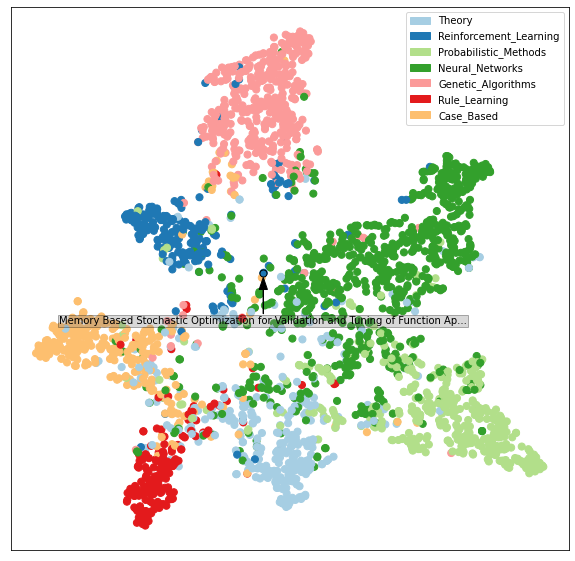

<IPython.core.display.Javascript object>

In [30]:
# visualize the embeddings of the model, colored by the original labels
visualize(z=z, y=data.y, hl=[7], text_type='title')

As we can see from the plot, the model's embedding splits the nodes by class quite well.

<IPython.core.display.Javascript object>

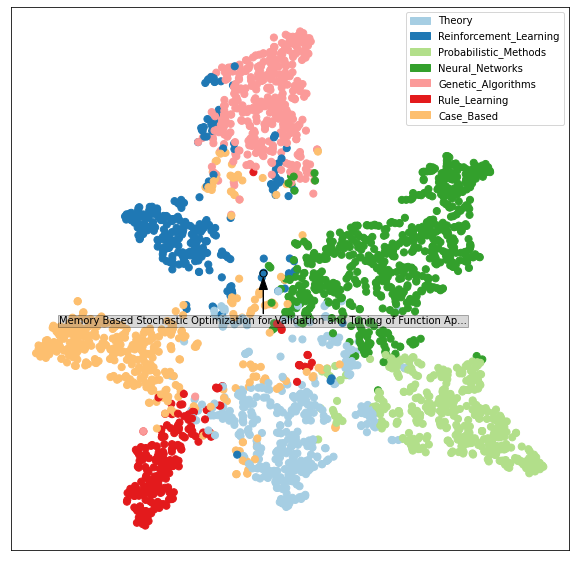

<IPython.core.display.Javascript object>

In [31]:
# visualize the embeddings of the model, colored by the predicted labels
visualize(z=z, out=out, color_pred=True, hl=[7], text_type='title')

The predicted labels result in less noisy groups, as is to be expected given that the node embeddings directly correspond to the predicted labels.

In [32]:
# example of predicting a single datapoint, alongside some of its metadata
predict_paper(7)
print()
print_paper(7)

<IPython.core.display.Javascript object>

Predicted: Reinforcement_Learning
True:      Reinforcement_Learning

Memory Based Stochastic Optimization for Validation and Tuning of Function Approximators

Artur Dubrawski and Jeff Schneider
January 4-7, 1997

Abstract: This paper focuses on the optimization of hyper-parameters for function approximators. We describe a kind of racing algorithm for continuous optimization problems that spends less time evaluating poor parameter settings and more time honing its estimates in the most promising regions of the parameter space. The algorithm is able to automatically optimize the parameters of a function approximator with less computation time. We demonstrate the algorithm on the problem of finding good parameters for a memory based learner and show the tradeoffs involved in choosing the right amount of computation to spend on each evaluation.


## Discussion
In this notebook we've discussed GNNs, and applied them to the problem of classifying papers according to their category. One thing to note is that these category labels are somewhat ambiguous - what makes a paper a Neural Network paper opposed to a Reinforcement Learning paper, for example, is difficult to objectively define. As such, we must take the performance with a grain of salt. Nevertheless, this dataset served as a nice demonstration for the utility of modeling a dataset as a graph.

Furthermore, you might have noticed that we did not use any form of minibatching in this tutorial, but rather passed the entire dataset through the model. This is on purpose, as minibatching (when considering one big graph) is non-trivial: If, when checking a certain node, some neighbors are not in the batch, we cannot process its embeddings (and their neighbors', and so on). A host of methods exist to deal with these issues (of which GraphSAGE[[2]](#hamilton2017) introduces one!), but we consider this to lie out of the scope of this tutorial.

To conclude, we credit the Node Classification tutorial provided by PyTorch Geometric[[4]](#pytorchgeom) as a foundation for this tutorial.

# References
<a name="pytorchgeomintro"></a>
[1] https://pytorch-geometric.readthedocs.io/en/latest/index.html 

<a name="hamilton2017"></a>
[2] Hamilton, W. L., Ying, R., & Leskovec, J. (2017, December). Inductive representation learning on large graphs. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 1025-1035).

<a name="cora"></a>
[3] https://relational.fit.cvut.cz/dataset/CORA

<a name="pytorchgeom"></a>
[4] https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

<a name="tsne"></a>
[5] https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html